# **Lab 8**

TI3155TU Deep Learning (2024 - 2025)

Adapted by Elena Congeduti from TU Delft CS4240 Deep Learning course.


# Instructions
**For this lab, we recommend working on Google Colab as it provides direct support for the TensorBoard library. To do this, select the 'Open in Colab' option from the notebook's homepage menu.**

Alternatively, you can work locally. In this case, you will need to set up your own virtual environment. Check the Lab Instructions in [Learning Material](https://brightspace.tudelft.nl/d2l/le/content/682797/Home?itemIdentifier=D2L.LE.Content.ContentObject.ModuleCO-3812764) on Brightspace for detailed information on the virtual environment configuration.

These labs include programming exercises and insight questions. Follow the instructions in the notebook. Fill in the text blocks to answer the questions and write your own code to solve the programming tasks within the designated part of the code blocks:

```python
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################


#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
```

Solutions will be shared the week after the lab is published. Note that these labs are designed for practice and are therefore **ungraded**.

In [ ]:
# Setup
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

#Additional Setup for MNIST-1D
!pip install mnist1d
    
import mnist1d
from mnist1d.data import get_templates, get_dataset_args, get_dataset
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

# 1 Sequential data and RNNs refresh

Until now, we have worked with data for which all samples have exactly the same input sizes or have the ability to mold the inputs (as pre-processing step) in similar sized objects without necessarily losing important information (e.g. resizing or cropping images). In many tasks though, inputs are of inherently different sizes without the possibility to be shrinked or expanded without losing essential embedded information in the process. As an example, think about a machine that is asked to assign a detailed description (input) to a specific category (output). In order to clarify the problem, two descriptions are provided that should be categorized as "house".

* 'Place in which people live.'
* 'Building that provides shelter to a family, often referred to as "home".'

Here, the input sizes (= the amount of characters in the sentence) differ by a lot. This task is therefore impossible for machines that are not able to cope with inputs of varying length. Consequently, the space of problems these machines are able to solve is highly limited as the majority of problems in this world have to deal with those variable input sizes. In analogy to varying input lengths, the same convincing argument could be used to argue that machines having the potential to produce different sized outputs are even increasing the amount of learnable problems. Think of machines that are asked to translate between two different languages (type of sequence-to-sequence learning). In this case machines must be equiped with the ability to produce length-varying outputs. These networks exist and one of them is the recurrent neural network (RNN).

A RNN consists of a hidden part that updates its internal hidden states recursively throughout the feedforward pass. The amount of recurrences depends solely on the length of the sequence. In this way, whatever you choose as (recurrence) function, the amount of hidden states is preserved independent of the sequence length. Mathematically this recurrence can be seen as a dynamical system strictly formulated as

$$ \mathbf{h}^{(t)} = f \left( \mathbf{h}^{(t-1)}, \mathbf{x}^{(t)} \right) $$

in which $\mathbf{h}$ is the hidden state, $\mathbf{x}$ the input and $f$ an arbitrary function. Most importantly, $t$ denotes how far you are in the sequence. If we choose the map between the hidden state at time $t-1$ and $t$ and the hidden state and the input to be linear, we arrive at

$$ \mathbf{h}^{(t)} =  \mathbf{h}^{(t-1)}\cdot W_{hh} +\mathbf{b}_{hh}+ \mathbf{x}^{(t)} \cdot W_{xh}+ \mathbf{b}_{xh}.$$

Here, $W_{hh}$ and $W_{xh}$ are the weights and $\mathbf{b}_{hh}$, $\mathbf{b}_{xh}$ the bias terms. Please note that $\mathbf{x}^{(t)}$ must have the same size at every iteration (which is perfectly possible if your sequence is partitioned in equivalently sized chunks of data). As we did before, we can make the map non-linear through the addition of an activation function:

$$ \mathbf{h}^{(t)} = \phi \left(  \mathbf{h}^{(t-1)}\cdot W_{hh} +\mathbf{b}_{hh}+ \mathbf{x}^{(t)} \cdot W_{xh}+ \mathbf{b}_{xh} \right)$$

for which the $\tanh$ function is often chosen in RNNs. So far we haven't yet introduced how the output is generated. There is several ways, but in its most general form the network generates an output at every step as

$$ \mathbf{o}^{(t)} = \psi \left(  \mathbf{h}^{(t)}\cdot W_{hy} + \mathbf{c} \right)$$

which can be regarded as an extra fully-connected layer on top of the hidden state. Please find out for yourself how the types given in the lecture (one-to-many, many-to-one and many-to-many) relate and change the equations above.

We will again use the MNIST-1D dataset. In this case, we provide sequences as inputs and ask for a single class as output. The output is therefore a sum over all *sequential* outputs

$$ \begin{aligned}
\mathbf{o} &= \frac{1}{\tau} \sum_{t=1}^{\tau} \mathbf{o}^{(t)} \\
 &= \psi \left( \frac{1}{\tau} \sum_{t=1}^{\tau} \mathbf{h}^{(t)}\cdot W_{hy} + \mathbf{c} \right).
\end{aligned}$$

in which $\tau$ is the length of the sequence. The figure below provides a visual interpretation.

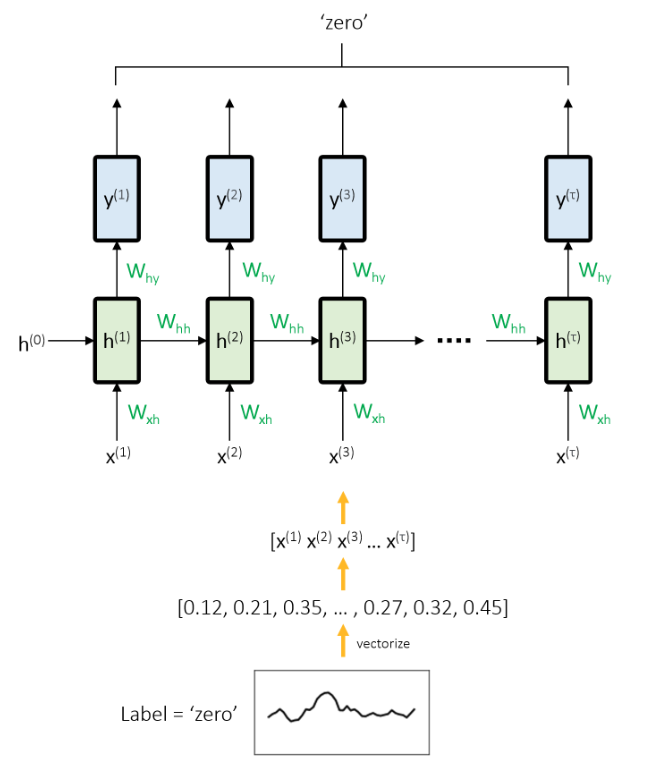

****
**Question 1.1:** In the context of predicting the future trajectory of a vehicle using RNNs, we have a training set with sequences of the vehicle's position in the 2D plane. Given a batch of $M$ input sequences $(x^1,\dots,x^T)^{(i)}$, for $i=1,\dots,M$, what are the appropriate dimensions of the weights $W_{xh},W_{hh}, W_{yh}$ and bias terms $b$ and $c$, according to the equations above?

<font color='green'> Write your answer here
</font>
****

# 2 *Vanilla* RNN

The specific architecture presented in the previous section is called *Vanilla* RNN as it is the simplest way of using recurrences. You will learn how to implement this Vanilla RNN for classifying handwritten digits.


Let us start by implementing only the hidden cell. We will couple the fully connected layer to produce the ouptut in a later stage. This means that for now the output of the forward pass will be the hidden state.

****
**Task 2.1:** Create weight and bias tensors with correct sizes. Don't forget to encapsulate weights and biases in `nn.Parameter`. Then, implement the forward pass of a Vanilla RNN.

[Hint: think about all the architectural hyperparameters and especially sizes of the input, hidden states, weights and outputs.]
****

In [ ]:
class VanillaRNN(nn.Module):
    """
    Vanilla recurrent neural network which has the following
    update rule:
        ht​ = tanh(W_xh * ​xt ​+ b_xh ​+ W_hh * ​h(t−1) ​+ b_hh​)
    """
    def __init__(self, input_size, hidden_size):
        super(VanillaRNN, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden biases
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #                            START OF YOUR CODE                        #
        ########################################################################
        # RNN parameters
        pass
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def reset_params(self):
        """
        Reset network parameters. Applies `init_params` to all parameters.
        """

        std = 1.0 / math.sqrt(self.hidden_size)
        self.weight_xh.data.uniform_(-std, std)
        self.weight_hh.data.uniform_(-std, std)
        self.bias_xh.data.uniform_(-std, std)
        self.bias_hh.data.uniform_(-std, std)


    def forward(self, x):
        """
        Args:
            x: input with shape (M, T, D) where M is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (M, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, M, D).
        x = x.transpose(0, 1)

        # Unpack dimensions
        T, M = x.shape[0], x.shape[1]

        # Initialize hidden states to zero. There will be one hidden state for
        # each input, so it will have shape of (M, H)
        h0 = torch.zeros(M, self.hidden_size, device=x.device)

        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #                           START OF YOUR CODE                         #
        ########################################################################
        pass 
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Stack the outputs
        #After this operation, output will have shape (T, N, H)
        y = torch.stack(y)

        #Reshape outputs
        y = y.transpose(0, 1)

        return y

****
**Question 2.2:** What is the shape of the output `y` before transposing? And after?

<font color='green'> Write your answer here
</font>
****

****
**Question 2.3:** What is the total amount of parameters (weights and biases) of our newtork for a given input size $D$ and hidden state size $H$?

<font color='green'> Write your answer here</font>
****

****
**Question 2.4:** Is it necessary to have two distinct bias tensors $b_{xh}$ and $b_{hh}$?

<font color='green'>Write your answer here </font>
****

We will now test this RNN on implementability.

In [ ]:
torch.manual_seed(123)

M, T, D = 2, 3, 4

x = torch.tensor([[[0.7957, 0.5273, 0.3984, 0.2958],
         [0.3043, 0.4366, 0.6209, 0.4625],
         [0.4545, 0.8004, 0.9374, 0.6986]],

        [[0.4338, 0.7891, 0.1068, 0.8820],
         [0.0045, 0.7733, 0.6096, 0.7807],
         [0.0209, 0.7052, 0.9621, 0.5020]]])

y_expected = torch.tensor([[[-0.1970, -0.0668, -0.0769,  0.5907, -0.0841,  0.2742, -0.6842,
           0.0232, -0.5910,  0.0012],
         [-0.0470,  0.2382, -0.2181,  0.6580,  0.0175,  0.3684, -0.5890,
          -0.2707, -0.6052, -0.2056],
         [ 0.0395,  0.3300, -0.2654,  0.7699, -0.0464,  0.3388, -0.7173,
          -0.0602, -0.5534, -0.3371]],

        [[-0.0902,  0.0316, -0.0349,  0.5173,  0.1766,  0.1269, -0.7318,
           0.0493, -0.6808,  0.0731],
         [ 0.0899,  0.2755, -0.2333,  0.6312,  0.0653,  0.2133, -0.7234,
          -0.0952, -0.6183, -0.2029],
         [ 0.0991,  0.2310, -0.1834,  0.7653,  0.0268,  0.2558, -0.6915,
           0.0239, -0.4378, -0.3501]]])

model = VanillaRNN(D, 10)
y = model(x)

print('Output check:', torch.allclose(y, y_expected, atol=1e-4))

You are ready to train the RNN on the MNIST-1D data set. Firs we load and structure the data as done in the previous labs.

In [ ]:
# Load dataset
args = get_dataset_args()
data = get_dataset(args, path='./mnist1d_data.pkl', download=True) # This is the default setting

# Set the batch size for training & testing
b_size = 100

# Convert 1D MNIST data to pytorch tensors
tensors_train = torch.Tensor(data['x']), torch.Tensor(data['y']).long()
tensors_test = torch.Tensor(data['x_test']),torch.Tensor(data['y_test']).long()

# Create training set and test set from tensors
train_set = TensorDataset(*tensors_train)
test_set = TensorDataset(*tensors_test)

# Create dataloaders from the training and test set for easier iteration over the data
train_loader = DataLoader(train_set, batch_size=b_size)
test_loader = DataLoader(test_set, batch_size=b_size)

# Get some data and check for dimensions
input, label = next(iter(train_loader))

# Check whether the data has the right dimensions
assert(input.shape == torch.Size([b_size, 40]))
assert(label.shape == torch.Size([b_size]))

# Display samples from dataset
templates = get_templates()
fig = plot_signals(templates['x'], templates['t'], labels=templates['y'],
                   args=get_dataset_args(), ratio=2.2, do_transform=True)

****
**Question 2.5:** What are the sequence length $T$ and the input size $D$ in this context?

<font color='green'> Write your answer here </font>
****


In similar fasion as in the previous lab, we create several *utility* functions that make life easy when defining a main code block to run from. The following utility functions are created:

1. `train`: trains and updates the model. Needs a training data set, specific model, optimizer and loss function as inputs. This training procedure updates for 1 epoch only (see `run` later on).
2. `test`: tests a model on a specific data set (can be train, validation and/or testset). Needs the loader, model and loss function as inputs.
3. `run`: To make playing with different models more straightforward, we provided a function in which you can chose across several types of RNN's: `vanilla`, `gru` or `lstm`. GRU and LSTM will be defined later. The training procedure is consistent with previous assignments and makes use of `train` and `test`. It needs as inputs the amount of epochs and hidden units.

Please be aware that the overarching model (including the fully connected output layer) is defined in `run` that consecutively 1. unflattens the input (to create chunks of data that can be sequentially fed into the network) 2. feedforwards through the RNN 3. flattens the output (=final hidden state) back again and 4. couples those flattened hidden states to the *real* outputs using a fully connected layer.

In [ ]:
def train(train_loader, model, optimizer, criterion, device):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        model: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Iterate through batches
    for i, data in enumerate(train_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move data to target device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss / len(train_loader), 100 * correct / total


def test(test_loader, model, criterion, device):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        model: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # Iterate through batches
        for data in test_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move data to target device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_loss / len(test_loader), 100 * correct / total


def run(rnn_type, epochs=100, hidden_size=10):
    """
    Run a test on MNIST-1D

    Args:
        rnn_type: can be either vanilla, gru or lstm
        epochs: number of epochs to run
        hidden_size: dimension of hidden state of rnn cell
    """
    # Create a writer to write to Tensorboard
    writer = SummaryWriter()

    if rnn_type == 'vanilla':
        rnn = VanillaRNN(1, hidden_size)
    elif rnn_type == 'gru':
        rnn = GRU(1, hidden_size)
    elif rnn_type == 'lstm':
        rnn = LSTM(1, hidden_size)
    else:
        raise Error('Unknown RNN type: ' + rnn_type)

    # Create classifier model
    model = nn.Sequential(OrderedDict([
        ('reshape', nn.Unflatten(1, (40, 1))),
        ('rnn', rnn),
        ('flat', nn.Flatten()),
        ('classifier', nn.Linear(40 * hidden_size, 10))
    ]))

    # Create loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 1e-2, weight_decay=1e-3)

    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = model.to(device)

    for epoch in tqdm(range(epochs)):
        # Train on data
        train_loss, train_acc = train(train_loader,
                                      model,
                                      optimizer,
                                      criterion,
                                      device)

        # Test on data
        test_loss, test_acc = test(test_loader,
                                   model,
                                   criterion,
                                   device)

        # Write metrics to Tensorboard
        writer.add_scalars('Loss', {
            'Train_{}'.format(rnn_type): train_loss,
            'Test_{}'.format(rnn_type): test_loss
        }, epoch)
        writer.add_scalars('Accuracy', {
            'Train_{}'.format(rnn_type): train_acc,
            'Test_{}'.format(rnn_type): test_acc
        }, epoch)


    print('\nFinished.')
    writer.flush()
    writer.close()

To come back to the benefit of the (especially last) utility function, you only have to run the following (ONE) line!

In [ ]:
run('vanilla')

We will inspect the results in tensorboard. Remember that Kaggle does not provide direct support for Tensorboard, so you will not able to see directly the results if you are working on Kaggle.

In [ ]:
# For Google Colab users only, local users run the next cell
# Run Tensorboard
%tensorboard --logdir runs/

In [ ]:
# For local users only
# Uncomment the last line
# run this cell once and wait for it to time out
# run this cell a second time and you should see the board

# %tensorboard --logdir runs/ --host localhost

In [ ]:
# To completely clean your tensorboard uncomment and run the following command.
!rm -r runs

# 3 Gated Recurrent Units
Theoretically, simple vanilla recurrent neural networks can learn long-term dependencies, but in practice, they often struggle due to vanishing or exploding gradients. Similar to the impact of the number of layers in a deep network, the length of the input sequences determine the amount of sequential multiplications for computing the gradients using the chain rule. Therefore, longe sequences are more likely to yield gradients that are either very small or very large (except for gradients close to 1). This decay or explosion of information through layers has a negative impact on learning capability of a network.

We will introduce two types of RNNs that are more complex structures designed to learn long-term dependencies. The first is the *Gated Recurrent Unit* (GRU) which is a simpler but still dedicated version of what we will discuss in the next section, which is the *Long Short-Term Memory* (LSTM).

The general idea is that the recurrent layer must somehow learn what *old information must be forgotton or kept* and what *new information must be added* to the current hidden state. That first property is carefully regulated with what is called the *reset gate*. The reset gate determines the slice of information in the ancestor hidden state that is suppressed and which is passed through. The reset signal is computed as

$$
\mathbf{r}^{(t)} = \sigma \left( \mathbf{h}^{(t-1)}\cdot W_{hr} + \mathbf{b}_{hr} + \mathbf{x}^{(t)} \cdot W_{xr}+ \mathbf{b}_{xr}\right).
$$

The first part of the new updated state is computed as the pointwise multiplication with the ancestor hidden state. The *update* gate determines what information should be added to the hidden state and is learned through

$$
\mathbf{z}^{(t)} = \sigma \left(  \mathbf{h}^{(t-1)} \cdot W_{hz}+ \mathbf{b}_{hz} +  \mathbf{x}^{(t)}\cdot W_{xz} + \mathbf{b}_{xz}\right)
$$

in which $\mathbf{z}$ is the *update* signal. Based on the reset gate we first compute the current *candidate* hidden state:

$$
\mathbf{n}^{(t)} = \tanh \left( \mathbf{r}^{(t)} \odot \left( \mathbf{h}^{(t-1)} \cdot  W_{hn}+ \mathbf{b}_{hn} \right) +  \mathbf{x}^{(t)} \cdot W_{xn}+ \mathbf{b}_{xn}\right).
$$

Depending on what should be forgotten about the ancestor hidden state, the current hidden state is defined as

$$
\mathbf{h}^{(t)} = \underbrace{\mathbf{z}^{(t)} \odot \mathbf{h}^{(t-1)}}_{\text{resets or puts through}} + \underbrace{\left( \mathbf{1}- \mathbf{z}^{(t)} \right) \odot \mathbf{n}^{(t)}}_{\text{adds new information (or not)}}.
$$

A block diagram makes life easier to understand the scheme of a general GRU.

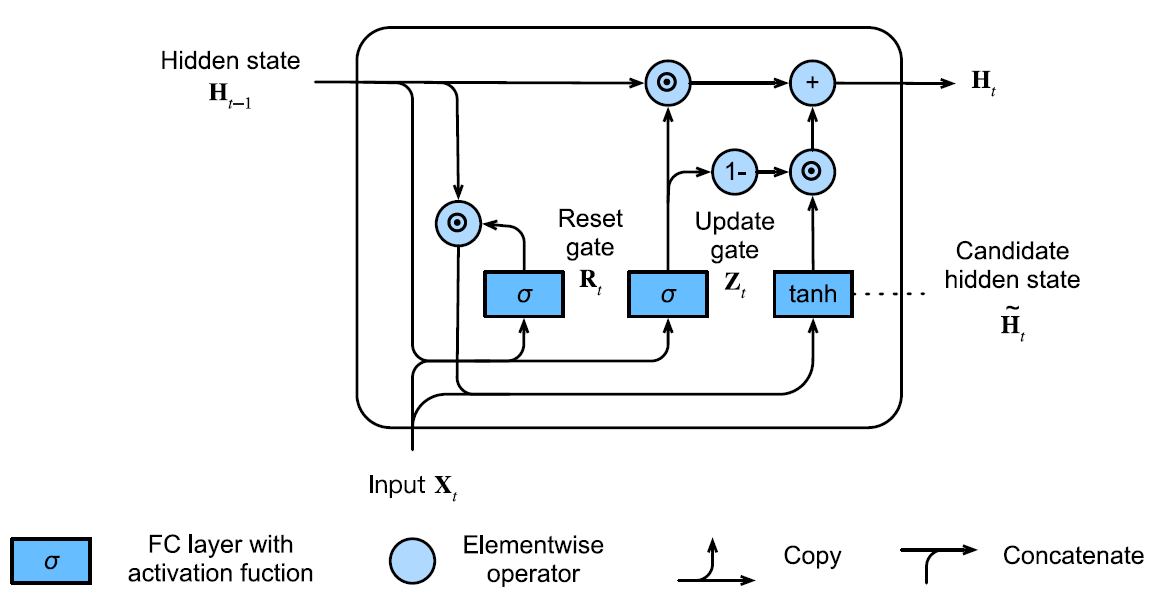


Now you can implement your own GRU.

****
**Task 3.1:** Create weight and bias tensors with correct sizes. Don't forget to encapsulate weights and biases in `nn.Parameter`. Make sure that weights and biases are defined by concatanations: that is, `self.weight_xh = [W_xr; W_xz; W_xn]`. Do a similar thing for `self.weight_hh`, `self.bias_xh`, and `self.bias_hh`. Then, implement the forward pass of a GRU.

Hint: for clarification, the formula's are given in the description of the class as well. (Be aware that they might be called slighly different.)
****

In [ ]:
class GRU(nn.Module):
    """
    Gated recurrent unit which has the following update rule:
        rt​ = σ(W_xr * ​xt​ + b_xr​ + W_hr * ​h(t−1) ​+ b_hr​)
        zt​ = σ(W_xz * ​xt​ + b_xz​ + W_hz * ​h(t−1) ​+ b_hz​)
        nt​ = tanh(W_xn * ​xt ​+ b_xn ​+ rt​(W_hn * ​h(t−1) ​+ b_hn​))
        ht​ = (1 − zt​) ⊙ nt ​+ zt​ ⊙ h(t−1)​​
    """
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden biases
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #                           START OF YOUR CODE                         #
        ########################################################################
        # GRU parameters
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def reset_params(self):
        """
        Initialize network parameters.
        """

        std = 1.0 / math.sqrt(self.hidden_size)
        self.weight_xh.data.uniform_(-std, std)
        self.weight_hh.data.uniform_(-std, std)
        self.bias_xh.data.uniform_(-std, std)
        self.bias_hh.data.uniform_(-std, std)


    def forward(self, x):
        """
        Args:
            x: input with shape (N, T, D) where N is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (N, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, N, D).
        x = x.transpose(0, 1)

        # Unpack dimensions
        T, N, H = x.shape[0], x.shape[1], self.hidden_size

        # Initialize hidden states to zero. There will be one hidden state for
        # each input, so it will have shape of (N, H)
        h0 = torch.zeros(N, H, device=x.device)

        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #                           START OF YOUR CODE                         #
        ########################################################################

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Stack the outputs. After this operation, output will have shape of
        # (T, N, H)
        y = torch.stack(y)

        # Switch time and batch dimension, (T, N, H) -> (N, T, H)
        y = y.transpose(0, 1)
        return y

Now we test our implementation of the GRU.

In [ ]:
torch.manual_seed(123)

M, T, D = 2, 3, 4

x = torch.tensor([[[0.7957, 0.5273, 0.3984, 0.2958],
         [0.3043, 0.4366, 0.6209, 0.4625],
         [0.4545, 0.8004, 0.9374, 0.6986]],

        [[0.4338, 0.7891, 0.1068, 0.8820],
         [0.0045, 0.7733, 0.6096, 0.7807],
         [0.0209, 0.7052, 0.9621, 0.5020]]])

y_expected = torch.tensor([[[ 0.1931,  0.1542, -0.0479, -0.0970, -0.1372, -0.2287, -0.1640,
           0.0329,  0.0138, -0.0188],
         [ 0.2726,  0.1844, -0.0813, -0.2337, -0.2087, -0.3678, -0.2680,
           0.0144, -0.0137,  0.0491],
         [ 0.3761,  0.2024, -0.0414, -0.2505, -0.2948, -0.4843, -0.4014,
           0.0866,  0.0301,  0.0544]],

        [[ 0.1997,  0.1099, -0.0130, -0.1473, -0.1177, -0.2509, -0.2016,
           0.0021, -0.0220,  0.0533],
         [ 0.2857,  0.1486, -0.0474, -0.2790, -0.1991, -0.4168, -0.3185,
           0.0090, -0.0471,  0.1243],
         [ 0.3317,  0.1926, -0.0856, -0.3359, -0.2664, -0.5120, -0.3863,
           0.0435, -0.0440,  0.1394]]])

model = GRU(D, 10)
y = model(x)

print('Output check:', torch.allclose(y, y_expected, atol=1e-4))

Now we test the GRU on the MNIST-1D problem

In [ ]:
run('gru')

To see the results, go back to [tensorboard](#scrollTo=XiZ-6Eg_5Mqt&line=1&uniqifier=1) and click the refresh button (image.png) in the top right corner.

****
**Question 3.2:** What do you observe comparing the training curves and accuracies?
****

#4 Long Short-Term Memories

The LSTM is a similar type of RNN to the GRU with a slightly more complex architecture. Both models employ mechanisms to determine what past information should be retained or discarded and what new information should be added during each update. Only the naming differs: the 'forget gate' in LSTM serves a similar function to the 'reset gate' in the GRU. The main difference is the addition of a new internal state, called the *cell* state. The cell state keeps track of the *state of the cell*. This cell state inspects, controls, and manages the retention of old information, discarding irrelevant portions, preserving valuable information, and adding new knowledge.


In complete analogy to the GRU, the *forget* signal (which is later multiplied with the ancestor cell state) is computed as

$$
\mathbf{f}^{(t)} = \sigma \left(  \mathbf{h}^{(t-1)} \cdot W_{hf}+ \mathbf{b}_{hf} +  \mathbf{x}^{(t)} \cdot W_{xf}+ \mathbf{b}_{xf}\right)
$$

in which again $W$ and $b$ represent the learnable parameters. Determining what new information should be added (or replaced) takes two steps. First we learn which part of the information will be either suppressed or highlighted (through the *information* signal, $\mathbf{i}$). This signal is than multiplied with the *candidate* cell state, $\mathbf{g}$, which is computed in similar fashion as before. The *update* signal is now computed as

$$
\begin{aligned}
\mathbf{z}^{(t)}
&= \mathbf{i}^{(t)} \odot \mathbf{g}^{(t)}\\
&= \sigma \left(  \mathbf{h}^{(t-1)} \cdot W_{hi}+ \mathbf{b}_{hi} + \mathbf{x}^{(t)}\cdot W_{xi}  + \mathbf{b}_{xi}\right) \odot \tanh \left(  \mathbf{h}^{(t-1)}\cdot W_{hg} + \mathbf{b}_{hg} + \mathbf{x}^{(t)}\cdot W_{xg}  + \mathbf{b}_{xg}\right).
\end{aligned}
$$

Combining both 'forget' and 'update' part results in the updated cell state as

$$
\mathbf{c}^{(t)} = \mathbf{f}^{(t)}  \odot \mathbf{c}^{(t-1)}  + \mathbf{z}^{(t)}.
$$

But We are not done yet. How do we update the hidden states based on information that resides in the cell state? The output will be a filtered version of the cell state. This filter is again learned on the basis of the ancestor hidden state and curren input unit. It will not surprise you that the filter is defined as

$$
\mathbf{h}^{(t)} = \sigma \left(  \mathbf{h}^{(t-1)} \cdot W_{ho}+ \mathbf{b}_{ho} +  \mathbf{x}^{(t)}\cdot W_{xo} + \mathbf{b}_{xo}\right)  \odot \tanh \left( \mathbf{c}^{(t)} \right).
$$

The scheme is again depicted below (observe that naming is not perfectly consistent: memory state instead of cell state)

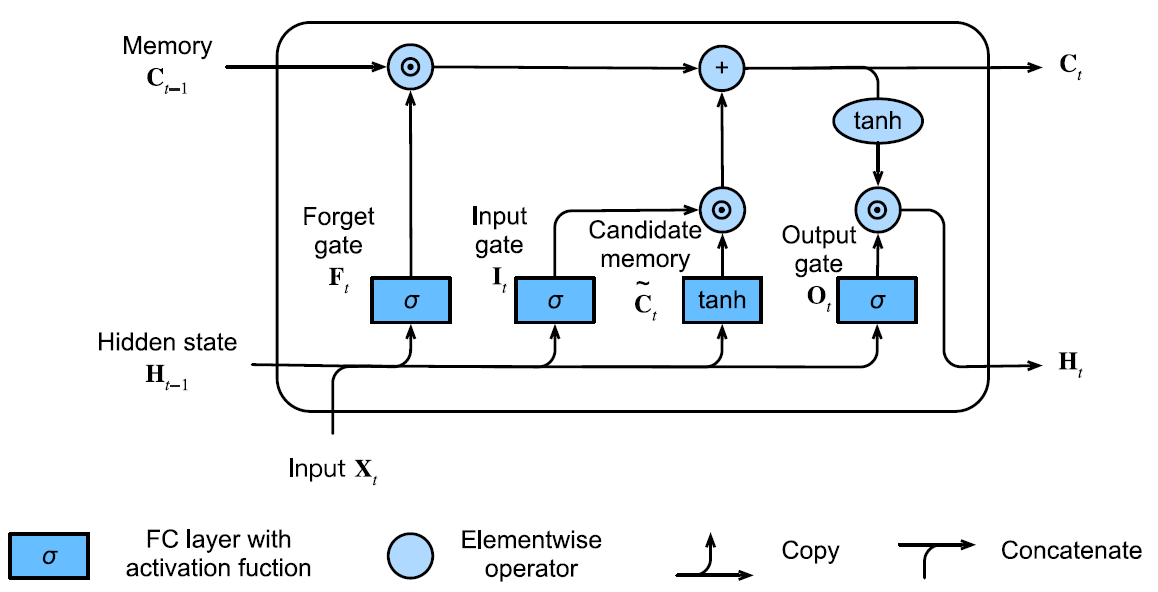

****
**Task 4.1:** Implement your own LSTM in the code block below (parameter definition and forward pass). Follow the same steps of Task 3.1.
****

In [ ]:
class LSTM(nn.Module):
    """
    Long short-term memory recurrent unit which has the following update rule:
        it ​= σ(W_xi * ​xt ​+ b_xi ​+ W_hi * ​h(t−1) ​+ b_hi​)
        ft​ = σ(W_xf * ​xt ​+ b_xf ​+ W_hf * ​h(t−1) ​+ b_hf​)
        gt ​= tanh(W_xg * ​xt ​+ b_xg ​+ W_hg * ​h(t−1) ​+ b_hg​)
        ot ​= σ(W_xo * ​xt ​+ b_xo​ + W_ho ​h(t−1) ​+ b_ho​)
        ct ​= ft​ ⊙ c(t−1) ​+ it ​⊙ gt​
        ht ​= ot​ ⊙ tanh(ct​)​
    """
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden biases
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #                           START OF YOUR CODE                         #
        ########################################################################
        # LSTM parameters
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def reset_params(self):
        """
        Initialize network parameters.
        """

        std = 1.0 / math.sqrt(self.hidden_size)
        self.weight_xh.data.uniform_(-std, std)
        self.weight_hh.data.uniform_(-std, std)
        self.bias_xh.data.uniform_(-std, std)
        self.bias_hh.data.uniform_(-std, std)


    def forward(self, x):
        """
        Args:
            x: input with shape (N, T, D) where N is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (N, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, N, D).
        x = x.transpose(0, 1)

        # Unpack dimensions
        T, N, H = x.shape[0], x.shape[1], self.hidden_size

        # Initialize hidden and cell states to zero. There will be one hidden
        # and cell state for each input, so they will have shape of (N, H)
        h0 = torch.zeros(N, H, device=x.device)
        c0 = torch.zeros(N, H, device=x.device)

        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #                           START OF YOUR CODE                         #
        ########################################################################

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Stack the outputs. After this operation, output will have shape of
        # (T, N, H)
        y = torch.stack(y)

        # Switch time and batch dimension, (T, N, H) -> (N, T, H)
        y = y.transpose(0, 1)
        return y

Again, test your LSTM.

In [ ]:
torch.manual_seed(123)

M, T, D = 2, 3, 4

x = torch.tensor([[[0.7957, 0.5273, 0.3984, 0.2958],
         [0.3043, 0.4366, 0.6209, 0.4625],
         [0.4545, 0.8004, 0.9374, 0.6986]],

        [[0.4338, 0.7891, 0.1068, 0.8820],
         [0.0045, 0.7733, 0.6096, 0.7807],
         [0.0209, 0.7052, 0.9621, 0.5020]]])

y_expected = torch.tensor([[[-0.0036, -0.0012, -0.0527, -0.0895, -0.1548,  0.0887, -0.1402,
           0.1327,  0.0201, -0.0073],
         [-0.0114, -0.0504, -0.0769, -0.1348, -0.1642,  0.0969, -0.2106,
           0.2081, -0.0096,  0.0205],
         [ 0.0280, -0.0849, -0.1072, -0.1575, -0.1827,  0.0974, -0.2321,
           0.2788, -0.0515,  0.0103]],

        [[-0.0330,  0.0147, -0.0665, -0.0761, -0.1594,  0.0656, -0.1720,
           0.0879, -0.0653, -0.0055],
         [-0.0350, -0.0300, -0.1045, -0.1350, -0.1626,  0.0742, -0.2439,
           0.1446, -0.1244,  0.0361],
         [-0.0053, -0.0773, -0.1306, -0.1765, -0.1549,  0.0886, -0.2632,
           0.2150, -0.1339,  0.0640]]])

model = LSTM(D, 10)
y = model(x)

print('Output check:', torch.allclose(y, y_expected, atol=1e-4))

As before, please run the LSTM on the same data set.

In [ ]:
run('lstm')

To see the results, go back to [tensorboard](#scrollTo=XiZ-6Eg_5Mqt&line=1&uniqifier=1) and click the refresh button (image.png) in the top right corner.

Well done, you implemented three succesful and versatile types of neural networks. If you have time left, play around with the network and/or training settings.

**That's all for this lab, see you in the next one!**

**Feedback Form:** please fill in the following form to provide https://forms.office.com/e/ThuxpYzjgf